In [1]:
%load_ext autoreload
%autoreload 2

In [65]:
from k2 import K2Processor
from evaluation import extract_params, spawn_model

In [4]:
import utils
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
import pandas as pd
import networkx as nx
import os

In [7]:
test_df = pd.read_csv('../data/results/K2_test_results.csv', index_col=0)

In [145]:
filt = test_df[(test_df.encoder == 'COLLAPSE') & (test_df.metric == 'precision') & (test_df.regime == 'class-1')].sort_values('value', ascending=False)
filt.head(20)

,encoder,model,threshold,datum_id,regime,metric,value
592,COLLAPSE,k20_r0_cutoff4.00_alpha0.001_tau0.00_lamnan.model,0.9,4limA.pkl,class-1,precision,1.0
624,COLLAPSE,k20_r0_cutoff4.00_alpha0.001_tau0.00_lamnan.model,0.9,1t8hA.pkl,class-1,precision,1.0
814,COLLAPSE,k20_r0_cutoff4.00_alpha0.001_tau0.00_lamnan.model,0.9,1v47A.pkl,class-1,precision,1.0
873,COLLAPSE,k20_r0_cutoff4.00_alpha0.001_tau0.00_lamnan.model,0.9,3rq4A.pkl,class-1,precision,1.0
880,COLLAPSE,k20_r0_cutoff4.00_alpha0.001_tau0.00_lamnan.model,0.9,5bwlA.pkl,class-1,precision,1.0
763,COLLAPSE,k20_r0_cutoff4.00_alpha0.001_tau0.00_lamnan.model,0.9,5ei9F.pkl,class-1,precision,1.0
160,COLLAPSE,k20_r0_cutoff4.00_alpha0.001_tau0.00_lamnan.model,0.9,3ttcA.pkl,class-1,precision,1.0
174,COLLAPSE,k20_r0_cutoff4.00_alpha0.001_tau0.00_lamnan.model,0.9,5hpdA.pkl,class-1,precision,1.0
1246,COLLAPSE,k20_r0_cutoff4.00_alpha0.001_tau0.00_lamnan.model,0.9,1hk8A.pkl,class-1,precision,1.0
225,COLLAPSE,k20_r0_cutoff4.00_alpha0.001_tau0.00_lamnan.model,0.9,3wkxA.pkl,class-1,precision,1.0


<Axes: >

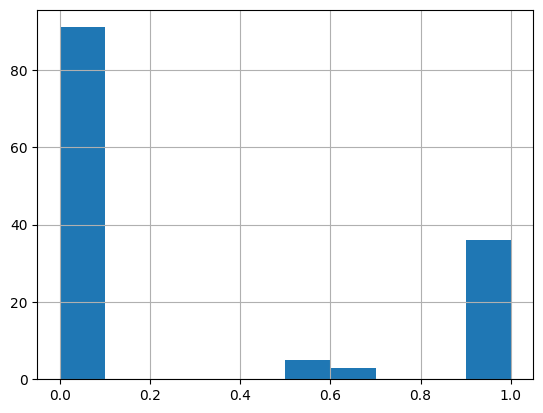

In [146]:
filt.value.hist()

In [147]:
high_precision = filt[filt.value > 0.5]

In [106]:
metal = 'ZN'
encoder = 'COLLAPSE'

processor_cache_dir = f"../data/{encoder}_{metal}_gridsearch_results/{encoder}-fitted_k2_processors"
model_cache_dir = f"../data/{encoder}_{metal}_gridsearch_results/{encoder}-fitted_k2_models"
G_test_dir = f"../data/{encoder}_{metal}_cutoff_test_graphs"
G_train_dir = f"../data/{encoder}_{metal}_cutoff_train_graphs"

model_str = "k25_r1_cutoff6.00_alpha0.100_tau4.00_lamnan.model" #using the best r>0 model for viz
k,r,cutoff,alpha,tau,lam = extract_params(model_str)

In [131]:
def create_visualizations(G_id, model_str, processor_cache_dir, model_cache_dir, G_dir, datatype="protein"):
    k,r,cutoff,alpha,tau,lam = extract_params(model_str)
    processor_name = "k%d_cutoff%.2f.processor" % (k, cutoff)
    G_dir = G_dir.replace('cutoff', '%.1f'%cutoff)

    proc = utils.deserialize_model(os.path.join(processor_cache_dir, processor_name))
    model = utils.deserialize_model(os.path.join(model_cache_dir, model_str))

    G_path = G_dir + "/" + G_id + ".pkl"
    G = utils.deserialize(G_path)
    sprite = utils.construct_sprite(G, proc)
    P = model.prospect(G)
    print('visualizing motif graph...')
    kernel_map = model.visualize_motif_graph(G)
    
    if datatype=='protein':
        print('visualizing sprite...')
        sprite_viz = utils.visualize_protein_sprite(sprite)
        print('visualizing prospect map...')
        prospect_map = utils.visualize_protein_sprite(P, prospect_flag=True)
        print('visualizing ground truth...')
        gt = utils.visualize_protein_sprite(utils.set_graph_emb(G, 'gt'), gt_flag=True)
    elif datatype=="image":
        sprite_map = utils.convert_graph2arr(sprite)
        sprite_viz = utils.visualize_quantizedZ(sprite_map)
        prospect_map = model.visualize_prospect_map(P)
        gt = model.visualize_prospect_map(P, gt_flag=True)

    return kernel_map, sprite_viz, prospect_map, gt

No G provided, showing model-wide kernel hash-graph
Displaying motif graph with log2 scaling


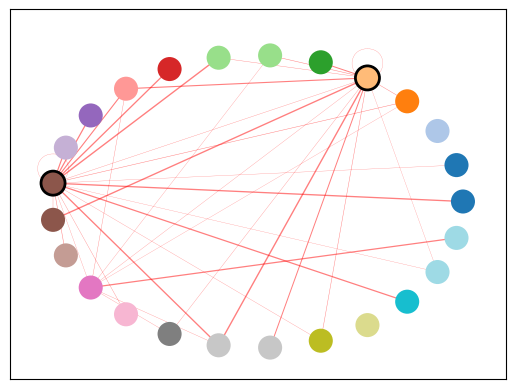

In [128]:
model = utils.deserialize_model(os.path.join(model_cache_dir, model_str))
model.visualize_motif_graph()

visualizing motif graph...
Displaying motif graph with log10 scaling
visualizing sprite...
visualizing prospect map...
visualizing ground truth...


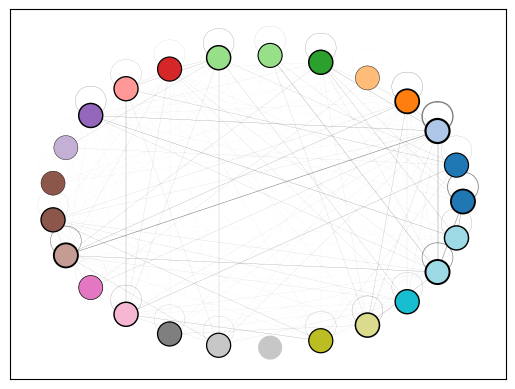

In [121]:
G_id = "1t8hA" 
kernel_map, sprite_viz, prospect_map, gt = create_visualizations(G_id, model_str, processor_cache_dir, model_cache_dir, G_dir, datatype="protein")

In [126]:
import time
def save_image(view, fname):
    img = view.render_image()
    
    while not img.value:
        time.sleep(0.1)
    
    with open(f"{fname}.png", "wb") as f:
        f.write(img.value)

In [119]:
sprite_viz

NGLWidget()

In [127]:
save_image(sprite_viz, f'{G_id}_sprite')

KeyboardInterrupt: 

In [118]:
prospect_map

NGLWidget()

In [117]:
# show_residues_around(gt, "ZN")
# gt.center("ZN")
gt

NGLWidget()

In [122]:
sprite_viz.render_image(trim=True, factor=2)

Image(value=b'', width='99%')

In [143]:
from tqdm import tqdm
def linearized_kernel(G_id, model_str, processor_cache_dir, model_cache_dir, G_dir, datatype="protein"):
    k,r,cutoff,alpha,tau,lam = extract_params(model_str)
    processor_name = "k%d_cutoff%.2f.processor" % (k, cutoff)
    G_dir = G_dir.replace('cutoff', '%.1f'%cutoff)

    proc = utils.deserialize_model(os.path.join(processor_cache_dir, processor_name))
    model = utils.deserialize_model(os.path.join(model_cache_dir, model_str))

    G_path = G_dir + "/" + G_id + ".pkl"
    G = utils.deserialize(G_path)
    sprite = utils.construct_sprite(G, proc)
    P = model.prospect(G)

    kernel_map = model.motif_graph_weight(sprite)
    n_weights = list(nx.get_node_attributes(kernel_map, 'n_weight').values())
    e_weights = list(nx.get_edge_attributes(kernel_map, 'e_weight').values())
    lin_kernel = n_weights + e_weights

    return lin_kernel

In [144]:
kernel_arr = []
for g_path in tqdm(high_precision.datum_id):
    G_id = g_path.strip('.pkl')
    kernel = linearized_kernel(G_id, model_str, processor_cache_dir, model_cache_dir, G_dir, datatype="protein")
    kernel_arr.append(kernel)
kernel_arr = np.array(kernel_arr)

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 42/42 [04:26<00:00,  6.35s/it]
